<a href="https://colab.research.google.com/github/liadmagen/NLP-Course/blob/master/exercises_notebooks_solutions/04_LM_PP_Attachment_classification__solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PP Attachment 

The Preposition Phrase attachment problem is the difficulty to decide if a preposition in a sentence is attached to a verb or a noun.

In some cases it may even confuse the reader. For example, the sentence:

> San Jose cops kill man with a knife

can be interpreted as either the man or the cops had a knife. The difference in the syntax parsing would be attaching the preposition phrase either to the Verb Phrase ("kill with knife")

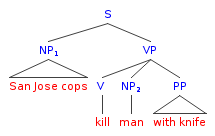

or to the Noun Phrase ("man with knife").

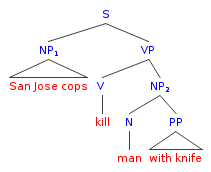


Let's try out the Preposition Phrase attachment classification!

Through this exercise, you'll practice classification of linguistic aspects of text.

# Setup
Loading the data

In [2]:
import csv

from tqdm.notebook import tqdm
from typing import Dict, List, Tuple
from random import choice
from urllib.request import urlopen


In [3]:
def read_pp_examples(file_url: str) -> List[Dict]:
  """Reads the pp samples from a remtoe url and loads them into a dictionary

  Args:
      file_url (str): a url to load the dataset from

  Returns:
      Dict: a dictionary with two keys: answer and pp
  """
  pp_examples = []
  
  for line in tqdm(urlopen(file_url)):
    line = line.decode("utf-8").strip().split()
    assert(len(line) == 5)
    v,n1,p,n2,answer = line
    pp_examples.append( {'answer':answer,'keywords':(v,n1,p,n2)} )
  return pp_examples

In [4]:
pp_samples_url = 'https://raw.githubusercontent.com/liadmagen/NLP-Course/master/dataset/pp_examples.txt'

In [5]:
pp_examples = read_pp_examples(pp_samples_url)


0it [00:00, ?it/s]

# Step #1 - Look at the data

Step 1 is (always) to examine the data!

That means to check the data statistics, load some sample at random and ensure it is correctly labeled, and if possible, plot and visualize the data (histograms, distribution, etc.). 

In [6]:
print(f"There are {len(pp_examples)} samples in the dataset")

There are 25858 samples in the dataset


In [7]:
print(choice(pp_examples))

{'answer': 'N', 'keywords': ('see', 'clouds', 'across', 'bay')}


Of course, we can reach the dictionary's parts by specifying the key in a squared brackets. 

In [8]:
random_example = choice(pp_examples)
random_example['keywords']

('are', 'source', 'of', 'liquidity')

In [9]:
random_example['answer']

'N'

# Step 2: Deciding on the measurement

In [10]:
# we can split the dataset simply through dividing the list 

amt = int(0.75 * len(pp_examples))
train_examples, test_examples = pp_examples[:amt], pp_examples[amt:]

print(len(train_examples), len(test_examples))

19393 6465


We'll define a classifier evaluator.

Given a set of examples and an evaluator, it returns the accuracy score

In [11]:
def evaluate_classifier(examples, pp_resolver):
  """evaluate the classifier and returns the accuracy score.

  Args:
      examples (List): a list of {'keywords':(v,n1,p,n2), 'answer':answer }
      pp_resolver (_type_): a model with a classify() function that maps from 
        (v,n1,p,n2) to 'N' / 'V'

  Returns:
      float: The accurcy score of the classifier
  """
  correct = 0.0
  incorrect = 0.0
  for example in examples:
      answer = pp_resolver.classify(example['keywords'])
      if answer == example['answer']:
          correct += 1
      else:
          incorrect += 1
  return correct / (correct + incorrect)


# Classifiers

Let's test it on an extremely naive classifiers:

In [12]:
class AlwaysSayN:
    """
    This naive clasifier answers always with 'Noun'
    """
    def __init__(self): pass
    def classify(self, pp):
        return 'N'


In [13]:
class AlwaysSayV:
    """
    This naive clasifier answers always with 'Verb'
    """
    def __init__(self): pass
    def classify(self, pp):
        return 'V'


In [14]:
evaluate_classifier(test_examples, AlwaysSayV())

0.4634184068058778

In [15]:
evaluate_classifier(test_examples, AlwaysSayN())

0.5365815931941222

We can see that saying always 'Noun', leads to an accuracy result of 53%.

---



It also means that our dataset is quite balaneced ;)

We could, instead, have tested which class has the majority and simply select it:

In [16]:
class MajorityClassResolver:
  def __init__(self, training_examples: List):
    """Initializes the class, testing which class is the majority and saves it as a property.

    Args:
        training_examples (List): A list of dictionary training examples.
    """
    answers = [item['answer'] for item in training_examples]
    num_n = len([a for a in answers if a == 'N'])
    num_v = len([a for a in answers if a == 'V'])
    if num_v > num_n:
        self.answer = 'V'
    else:
        self.answer = 'N'

  def classify(self, pp: Tuple) -> str:
    """classify a 4 keywords tuple as N or V attachment, based on the previously calculated majority class

    Args:
        pp (Tuple): a tuple of V, N1, PP, N2 to be classified

    Returns:
        str: the prediction - N or V
    """
    return self.answer


In [17]:
evaluate_classifier(test_examples, MajorityClassResolver(train_examples))

0.5365815931941222

Or make it a bit more sophisticated by peeking at the training examples:

In [18]:
class LookupResolver:
  def __init__(self, training_examples: List):
    """Initializes the class, load all the training dataset into the memory and during prediction, return the answer if the keywords match a previously saved one. 

    Args:
        training_examples (List): _description_
    """
    self.answers = {}
    for item in training_examples:
        self.answers[item['keywords']] = item['answer']
    self.backoff = MajorityClassResolver(training_examples)
      
  def classify(self, pp: Tuple) -> str:
    """Classify a 4 keywords tuple as N or V attachment.
     If the tuple was found in the previously stored answers, return it.
     Otherwise, return the majority class.

    Args:
        pp (Tuple): a tuple of V, N1, PP, N2 to be classified

    Returns:
        str: the prediction - N or V
    """
    if pp in self.answers:
        return self.answers[pp]
    else:
        return self.backoff.classify(pp)

In [19]:
# If you want to understand what is stored in the `answers` property, uncomment and run the following line:
# LookupResolver(train_examples).answers

In [20]:
evaluate_classifier(test_examples, LookupResolver(train_examples))

0.6009280742459396

# Exercise - Your Turn:

Implement a discriminative PP-attachment model, using a classifier of your choice (i.e. - Naive Bayes Classifier https://web.stanford.edu/~jurafsky/slp3/4.pdf, [Support Vector Machine](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC), etc.) from a toolkit such as [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB).

Possible features for back-off algorithm or ML one:

Single items ​
* Identity of v ​
* Identity of p ​
* Identity of n1 ​
* Identity of n2 ​

Pairs:​
* dentity of (v, p) ​
* Identity of (n1, p) ​
* Identity of (p, n1)​

Triplets:​
* Identity of (v, n1, p)​
* Identity of (v, p, n2) ​
* Identity of (n1, p, n2) ​

Quadruple:​
* Identity of (v, n1, p, n2)​


Corpus Level:​

* Have we seen the (v, p) pair in a 5-word window in a big corpus?​
* Have we seen the (n1, p) pair in a 5-word window in a big corpus? ​
* Have we seen the (n1, p, n2) triplet in a 5-word window in a big corpus?​
*  Also: we can use counts, or binned counts.​
* You can use a bigger corpus for additional training purposes as well.

Distance:​
* Distance (in words) between v and p ​
* Distance (in words) between n1 and p​

For the corpus level features, you can simply load one of the english corpuses in NLTK (such as [brown - but don't forget to download it first](https://www.nltk.org/book/ch02.html)). If you use a tagged corpus - such that the words are tagged by their parts of speech, you can create more interesting linguistic-related features.

You can also consider using [WordNet](https://wordnet.princeton.edu/), a large *lexical* database of English words, which is also [implemented in NLTK](https://www.nltk.org/howto/wordnet.html). 

Finally, if you need inspiration and ideas, here are some selected papers:
- [An Analysis of Prepositional-Phrase Attachment Disambiguation](http://ejournals.asia/stj1/ijclr2.pdf) - an overview of different papers dealing with this problem using different methods (kNN, SVN, etc.).
- [The spy saw a cop with a telescope: Who has the telescope?](https://www.semanticscholar.org/paper/The-spy-saw-a-cop-with-a-telescope%3A-Who-has-the-Yan-Nguyen/3220ad0619b72404cb9b1acb9e093a8a564f0f4e) - An linguistic analysis of the potentials reasons (and features) to disambiguify pp attachment. 
- [PREPOSITIONAL PHRASE ATTACHMENT AMBIGUITY RESOLUTION USING SEMANTIC HIERARCHIES](https://eprints.mdx.ac.uk/2471/1/ppattachhier.pdf)
- [Corpus Based PP Attachment Ambiguity Resolution with a Semantic Dictionary](https://aclanthology.org/W97-0109.pdf)

## First step - having a PROPER look at the data

Personally, I find it convenient to use pandas, but this is not a must.

In [21]:
import nltk
import pandas as pd

df = pd.DataFrame([ex['keywords'] for ex in train_examples], columns=['v', 'n1', 'p', 'n2'])
df['target'] = [ex['answer'] for ex in train_examples]
df_codes = pd.DataFrame()

for col in df.columns:
  df[col] = df[col].str.lower().astype('category')
  df_codes[col] = df[col].cat.codes

df.describe().T

,count,unique,top,freq
v,19393,2990,is,759
n1,19393,3970,%,1302
p,19393,62,of,5049
n2,19393,4792,$,1227
target,19393,2,n,10625


### Preposition distribution

In [22]:
nltk.FreqDist(df[df['target']=='n']['p'])

FreqDist({'of': 4838, 'in': 1499, 'for': 1170, 'on': 612, 'to': 460, 'from': 375, 'with': 367, 'at': 179, 'as': 172, 'by': 154, ...})

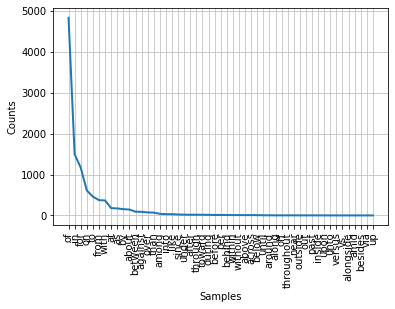

In [23]:
nltk.FreqDist(df[df['target']=='n']['p']).plot()

In [24]:
nltk.FreqDist(df[df['target']=='v']['p'])

FreqDist({'in': 1847, 'to': 1541, 'for': 905, 'from': 836, 'on': 585, 'with': 512, 'at': 507, 'as': 334, 'by': 268, 'of': 211, ...})

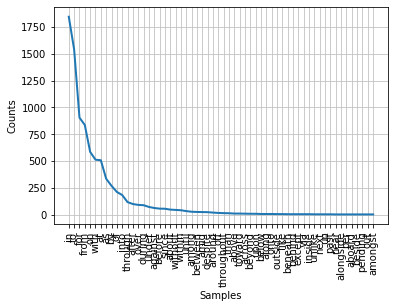

In [25]:
nltk.FreqDist(df[df['target']=='v']['p']).plot()

Pandas is also a great tool to visualize the distribution:

In [26]:
df_p_distribution = df.groupby(['p', 'target']).agg({'target': 'count'}); df_p_distribution

target
p       target        
aboard  n            0
        v            1
about   n          145
        v           46
above   n            8
...                ...
with    v          512
within  n            9
        v           40
without n            9
        v           43

[124 rows x 1 columns]

In [27]:
df_p_distribution_pct = df_p_distribution.groupby(level=0).apply(lambda x: x * 100. / x.sum()); df_p_distribution_pct

target
p       target            
aboard  n         0.000000
        v       100.000000
about   n        75.916230
        v        24.083770
above   n        47.058824
...                    ...
with    v        58.248009
within  n        18.367347
        v        81.632653
without n        17.307692
        v        82.692308

[124 rows x 1 columns]

This way we can even find good candidates for 'almost always X':

In [28]:
df_p_distribution_pct[df_p_distribution_pct['target'] > 90]

,,target
p,target,
aboard,v,100.000000
amid,v,95.833333
amongst,v,100.000000
beneath,v,100.000000
beside,v,100.000000
besides,n,100.000000
beyond,v,100.000000
despite,v,100.000000
except,v,100.000000


or create a list out of them:

In [29]:
easy_prep = df_p_distribution_pct[df_p_distribution_pct['target'] > 90].index.get_level_values(0).to_list()
easy_prep

['aboard',
 'amid',
 'amongst',
 'beneath',
 'beside',
 'besides',
 'beyond',
 'despite',
 'except',
 'next',
 'of',
 'onto',
 'pending',
 'per',
 'unlike',
 'unto',
 'versus',
 'vs.']

In [30]:
df[df['p']=='per']

,v,n1,p,n2,target
808,report,earnings,per,share,n
1247,require,spoonfuls,per,washload,n
1507,achieve,increase,per,share,n
2766,processes,instructions,per,second,v
5037,have,computers,per,employee,n
7750,had,investigators,per,contracts,n
8243,produce,barrels,per,day,n
12435,eat,apples,per,capita,n
12726,use,fertilizer,per,acre,n
14085,receive,cent,per,share,n


In [31]:
df[df['p']=='into'].sort_values('n2')

,v,n1,p,n2,target
7577,convert,shares,into,%,v
1367,support,prices,into,1990,v
2314,keep,pressure,into,1990s,v
3910,drive,spending,into,1991,v
8099,translate,idea,into,action,v
...,...,...,...,...,...
15886,convert,movies,into,video,v
15882,transform,film,into,video,v
16491,restart,flights,into,vietnam,n
17847,plunging,electrodes,into,water,v


#### Preposition Distribution - summary

We can see that some prepositions ('of', 'per', 'amid') tends to belong to a single class, while some others ('in', 'for') are nearly half-half between the classes.

### Distribution of the rest of the classes

In [32]:
df['v'].value_counts().head(20)

is           759
rose         388
had          374
was          338
have         271
are          247
be           243
has          233
buy          205
fell         168
reported     168
sell         156
make         144
's           142
been         133
made         130
increased    129
take         123
posted       111
put          110
Name: v, dtype: int64

Many words seem to be in different forms (past, present). Let's check if there are differences: 

In [33]:
df[df['v']=='increased']['target'].value_counts()

v    108
n     21
Name: target, dtype: int64

In [34]:
df[df['v']=='increase']['target'].value_counts()

v    54
n    45
Name: target, dtype: int64

In [35]:
df[df['v']=='reported']['target'].value_counts()

n    151
v     17
Name: target, dtype: int64

In [36]:
df[df['v']=='report']['target'].value_counts()

n    59
v    15
Name: target, dtype: int64

In [37]:
df[df['v'].str.startswith('report')]['target'].value_counts()

n    220
v     34
Name: target, dtype: int64

In [38]:
df['n1'].value_counts()

%                1302
stake             202
loss              189
shares            155
part              154
                 ... 
nerves              1
neighborhoods       1
corporations        1
corpse              1
zip                 1
Name: n1, Length: 3970, dtype: int64

In [39]:
df['n2'].value_counts()

$           1227
%            274
market       217
quarter      198
years        177
            ... 
lumpur         1
camps          1
lyondell       1
lyonnais       1
zone           1
Name: n2, Length: 4792, dtype: int64

In [40]:
df['n2'].value_counts().head(20)

$            1227
%             274
market        217
quarter       198
years         177
company       148
year          134
shares        134
yen           114
months        101
time           92
trading        87
stock          84
inc.           81
u.s.           81
markets        77
companies      73
corp.          72
business       69
september      68
Name: n2, dtype: int64

In [41]:
df[df['n1']=='%']

,v,n1,p,n2,target
32,distribute,%,of,revenues,n
33,distribute,%,as,grants,v
75,dropped,%,to,$,v
76,dropped,%,from,$,v
77,fell,%,to,$,v
...,...,...,...,...,...
19271,declined,%,to,$,v
19272,declined,%,from,$,v
19273,rose,%,to,$,v
19274,rose,%,from,$,v


In [42]:
df[df['n1']=='%']['target'].value_counts()

v    988
n    314
Name: target, dtype: int64

In [43]:
df[df['n2']=='$']

,v,n1,p,n2,target
4,leaving,spending,at,$,v
75,dropped,%,to,$,v
76,dropped,%,from,$,v
77,fell,%,to,$,v
78,fell,%,from,$,v
...,...,...,...,...,...
19275,closed,yesterday,at,$,v
19279,buy,company,for,$,v
19343,had,revenue,of,$,n
19344,closed,yesterday,at,$,v


In [44]:
df[df['n2']=='$']['target'].value_counts()

v    781
n    446
Name: target, dtype: int64

In [45]:
df[df['n2']=='$']['target'].value_counts()

v    781
n    446
Name: target, dtype: int64

In [46]:
df[df['n2']=='years']['target'].value_counts()

v    134
n     43
Name: target, dtype: int64

In [47]:
df[df['n2']=='year']['target'].value_counts()

v    76
n    58
Name: target, dtype: int64

In [48]:
df[df['n2']=='months']['target'].value_counts()

v    74
n    27
Name: target, dtype: int64

In [49]:
df[df['n2']=='month']['target'].value_counts()

v    14
n     5
Name: target, dtype: int64

It seems that many of the nouns appear in singular/pluarl forms, and in some cases both forms actually lead to the same result distribution. 

## On Generating N-Grams

In [50]:
from sklearn.feature_extraction.text import CountVectorizer

The input of *any* machine learning model must be numerical. Since words (nor characters) aren’t numbers, we have to work a bit to convert them into a numerical representation.

Such a numerical representation is also called a vector (a fancy name for a list of numbers…). A common way to achieve such vector is to perform measurements on the text (as we discussed in the first sessions – performing measurement on an apple). 

Such features could be the identity of a single word, given as an index number, or its frequency in a corpus or in the sentence, or TF-IDF on a corpus. Features can also be a composition of multiple words together (e.g., only the verb and the preposition), with the same or other techniques. This is also called an **n-gram**. 

One way to vectorize text is using that count transformer ([CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)) from scikit-learn. These vectorizers work in two part: 
*	First they learn ([fit](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer.fit)) from some input data. In the case of CountVectorizer, it expects a list of sentences (a corpus) to learn from. It will then learn how many different words (types) the corpus contains, and will build a vocabulary for those words: each word will get an index number. It also cleans up the text from stop words and punctuation, and you could even ask it to learn representations of n-grams, instead of single words (a parameter of the CountVectorizer itself).
*	After learning the size of the vocabulary, it can transform any list of text into a vectorized representation. Given a list of new text inputs, sentences in different lengths (also the list itself can be any length – for example, it can be made of a single sentence, but it has to be a list), the [transform](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer.transform) method will return a vector representation in the size of the learned vocabulary, where every position represent a specific word (a type) from the learned corpus. The value on that position is the number of occurrences of that word in that given sentence. Piling up these three vectors, one on top of the other, would yield a matrix (a table / excel sheet of numbers), where every column represent a specific word in our vocabulary.
*	`X_transformed = vectorizer.fit_transform(X)` ▶ [fit_transform](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer.fit_transform) is a method that does both parts (fitting – counting the vocabulary types, and then converting that input text into the vector or even a matrix if there are more than one string) in one go.
*	The result of the CountVectorizer is indeed a (sparse) matrix in a form of scipy’s scr_matrix. To convert it into an array, you can call its method “toarray()”:


In [51]:
# to use the CountVectorizer, we must convert the tuples into "full" sentences;
joined_sentences = [' '.join(example['keywords']) for example in train_examples[:10]]
joined_sentences

['creating obstacle to sale',
 'restrict RTC to borrowings',
 'maintain assets of thrifts',
 'leaving spending for bailout',
 'leaving spending at $',
 'including interest over years',
 'subtracting value of assets',
 'say opponents of plan',
 'pay price of consultation',
 'want kind of flexibility']

In [52]:
# CountVectorizer would, by default, tokenize the sentence through spaces 
# and collect a vocabulary from all the different words it finds:
vect = CountVectorizer()
vect.fit(joined_sentences)
print(f"vocabulary size: {len(vect.vocabulary_)}")
vect.get_feature_names_out()

vocabulary size: 31


array(['assets', 'at', 'bailout', 'borrowings', 'consultation',
       'creating', 'flexibility', 'for', 'including', 'interest', 'kind',
       'leaving', 'maintain', 'obstacle', 'of', 'opponents', 'over',
       'pay', 'plan', 'price', 'restrict', 'rtc', 'sale', 'say',
       'spending', 'subtracting', 'thrifts', 'to', 'value', 'want',
       'years'], dtype=object)

In [53]:
# We can use it to generate n-grams sized 1 (unigram) to 4:
vect = CountVectorizer(ngram_range=(1, 4))
vect.fit(joined_sentences)
print(f"vocabulary size: {len(vect.vocabulary_)}")
vect.get_feature_names_out()

vocabulary size: 87


array(['assets', 'assets of', 'assets of thrifts', 'at', 'bailout',
       'borrowings', 'consultation', 'creating', 'creating obstacle',
       'creating obstacle to', 'creating obstacle to sale', 'flexibility',
       'for', 'for bailout', 'including', 'including interest',
       'including interest over', 'including interest over years',
       'interest', 'interest over', 'interest over years', 'kind',
       'kind of', 'kind of flexibility', 'leaving', 'leaving spending',
       'leaving spending at', 'leaving spending for',
       'leaving spending for bailout', 'maintain', 'maintain assets',
       'maintain assets of', 'maintain assets of thrifts', 'obstacle',
       'obstacle to', 'obstacle to sale', 'of', 'of assets',
       'of consultation', 'of flexibility', 'of plan', 'of thrifts',
       'opponents', 'opponents of', 'opponents of plan', 'over',
       'over years', 'pay', 'pay price', 'pay price of',
       'pay price of consultation', 'plan', 'price', 'price of',
     

These n-grams follow the sentence structure. We would like to also have combinations of words which are not near each other in the sentence, such as `(v, p)`

How can we achieve that?

In [126]:
# Getting the missing n-grams can be done in one of two ways.
# One way is to synthetically generate the pairs, then add them all up into 
# one corpus.

keywords_list = [example['keywords'] for example in train_examples[:10]]
sentence_list = [" ".join(tpl) for tpl in keywords_list]
print(sentence_list)

additional_ngrams_1 = [' '.join((tuple_item[0], tuple_item[2], tuple_item[3])) for tuple_item in keywords_list]
print(additional_ngrams_1)
additional_ngrams_2 = [' '.join((tuple_item[0], tuple_item[3])) for tuple_item in keywords_list]
print(additional_ngrams_2)
additional_ngrams_3 = [' '.join((tuple_item[1], tuple_item[3])) for tuple_item in keywords_list]
print(additional_ngrams_3)

corpus = additional_ngrams_1 + additional_ngrams_2 + additional_ngrams_3 + [" ".join(tpl) for tpl in keywords_list]

vect = CountVectorizer(ngram_range=(1, 4))
vect.fit(corpus)
print(f"vocabulary size (ngrams): {len(vect.vocabulary_)}")
ngrams = vect.get_feature_names_out()

# test with "creating obstacle to sale"
assert "creating" in ngrams
assert "obstacle" in ngrams
assert "to" in ngrams
assert "sale" in ngrams

assert "creating obstacle" in ngrams
assert "creating to" in ngrams
assert "creating sale" in ngrams 
assert "obstacle to"  in ngrams
assert "obstacle sale" in ngrams
assert "to sale"  in ngrams

assert "obstacle to sale"  in ngrams
assert "creating obstacle to" in ngrams
# assert set("creating obstacle sale".split(" ")) in (set(ng.split(" ")) for ng in ngrams) # <-- will fail since it is not in the dataset
# (but since it contains no preposition - we're ok with that!)

ngrams

['creating obstacle to sale', 'restrict RTC to borrowings', 'maintain assets of thrifts', 'leaving spending for bailout', 'leaving spending at $', 'including interest over years', 'subtracting value of assets', 'say opponents of plan', 'pay price of consultation', 'want kind of flexibility']
['creating to sale', 'restrict to borrowings', 'maintain of thrifts', 'leaving for bailout', 'leaving at $', 'including over years', 'subtracting of assets', 'say of plan', 'pay of consultation', 'want of flexibility']
['creating sale', 'restrict borrowings', 'maintain thrifts', 'leaving bailout', 'leaving $', 'including years', 'subtracting assets', 'say plan', 'pay consultation', 'want flexibility']
['obstacle sale', 'RTC borrowings', 'assets thrifts', 'spending bailout', 'spending $', 'interest years', 'value assets', 'opponents plan', 'price consultation', 'kind flexibility']
vocabulary size (ngrams): 124


array(['assets', 'assets of', 'assets of thrifts', 'assets thrifts', 'at',
       'bailout', 'borrowings', 'consultation', 'creating',
       'creating obstacle', 'creating obstacle to',
       'creating obstacle to sale', 'creating sale', 'creating to',
       'creating to sale', 'flexibility', 'for', 'for bailout',
       'including', 'including interest', 'including interest over',
       'including interest over years', 'including over',
       'including over years', 'including years', 'interest',
       'interest over', 'interest over years', 'interest years', 'kind',
       'kind flexibility', 'kind of', 'kind of flexibility', 'leaving',
       'leaving at', 'leaving bailout', 'leaving for',
       'leaving for bailout', 'leaving spending', 'leaving spending at',
       'leaving spending for', 'leaving spending for bailout', 'maintain',
       'maintain assets', 'maintain assets of',
       'maintain assets of thrifts', 'maintain of', 'maintain of thrifts',
       'maintain thri

The other way requires a bit of a hack to the sentences, appending the words at the end of the sentence to generate additional pairs.

To get the pairs `(v, p)`, `(v, p, n2)` from `(v, n1, p, n2)` we need to generate
```(v, n1, p, n2, v, p)```

Getting the missing n-grams requires a bit of a hack to the sentences.
Here we will get the pairs `(v, p)`, `(v, p, n2)`

In [134]:
# To get the pairs (v, p), (v, p, n2) from (v, n1, p, n2) we need to generate a sentence like:
# (v, n1, p, n2, v, p, n1, n2)
# This would cover the following bi-grams:
# (v, n1), (n1, p), (p, n2), (n2, v), (v, p), 
# and the following trigrams:
# (v, n1, p), (n1, p, n2), (p, n2, v), and also (n2, v, p) which is kinda like 
# the previous one...
# and the 4-grams - which are again, all the same for us.


# isolating the keywords from the train_examples
keywords_list = [example['keywords'] for example in train_examples[:10]]
# generating n-grams artificially by reordering the words:
additional_ngrams = [' '.join((tuple_item[0], tuple_item[2], tuple_item[3], tuple_item[1])) for tuple_item in keywords_list]

# putting both together
corpus = [sentence + " " + ngrams for sentence, ngrams in zip(joined_sentences, additional_ngrams)]
print(corpus)

vect = CountVectorizer(ngram_range=(1, 4))
vect.fit(corpus)
print(len(vect.vocabulary_))

ngrams = vect.get_feature_names_out()
# test with "creating obstacle to sale"
assert "creating" in ngrams
assert "obstacle" in ngrams
assert "to" in ngrams
assert "sale" in ngrams

assert "creating obstacle" in ngrams
assert "creating to" in ngrams
# assert "creating sale" in ngrams # <-- this would fail - but we  have "sale creating" intead
assert "sale creating" in ngrams
assert "obstacle to"  in ngrams
assert "sale obstacle" in ngrams
assert "to sale"  in ngrams
assert "obstacle to sale"  in ngrams
assert "creating obstacle to" in ngrams
# assert set("creating obstacle sale".split(" ")) in (set(ng.split(" ")) for ng in ngrams) # <-- will fail since not in the dataset
# (but since it contains no preposition - we're ok with that!)

ngrams

['creating obstacle to sale creating to sale obstacle', 'restrict RTC to borrowings restrict to borrowings RTC', 'maintain assets of thrifts maintain of thrifts assets', 'leaving spending for bailout leaving for bailout spending', 'leaving spending at $ leaving at $ spending', 'including interest over years including over years interest', 'subtracting value of assets subtracting of assets value', 'say opponents of plan say of plan opponents', 'pay price of consultation pay of consultation price', 'want kind of flexibility want of flexibility kind']
195


array(['assets', 'assets of', 'assets of thrifts',
       'assets of thrifts maintain', 'assets subtracting',
       'assets subtracting of', 'assets subtracting of assets',
       'assets value', 'at', 'at leaving', 'at leaving at',
       'at leaving at spending', 'at spending', 'bailout',
       'bailout leaving', 'bailout leaving for',
       'bailout leaving for bailout', 'bailout spending', 'borrowings',
       'borrowings restrict', 'borrowings restrict to',
       'borrowings restrict to borrowings', 'borrowings rtc',
       'consultation', 'consultation pay', 'consultation pay of',
       'consultation pay of consultation', 'consultation price',
       'creating', 'creating obstacle', 'creating obstacle to',
       'creating obstacle to sale', 'creating to', 'creating to sale',
       'creating to sale obstacle', 'flexibility', 'flexibility kind',
       'flexibility want', 'flexibility want of',
       'flexibility want of flexibility', 'for', 'for bailout',
       'for bailo

In [86]:
# about zip - it combines two same-length lists together, so that we can 
# loop on both simultanously:
[(a, b) for a, b in zip(range(5), range(10,15))]

[(0, 10), (1, 11), (2, 12), (3, 13), (4, 14)]

### On plotting multidimensional data

Our data is multidimensional. Every sentence have many words (more than 2 or 3), which makes it hard to visualize and plot all the data.

To overcome it, there are set of tools that use unsupervised machine learning to reduce the dimensionality of the data.

Examples for such tools are:
- Principle Component Analysis ([PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)) and its partner for sparsed matrices:
- Singular Value Decomposition ([TruncatedSVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html)) 
- T-distributed Stochastic Neighbor Embedding ([T-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) for short)
- [U-MAP](https://umap-learn.readthedocs.io/en/latest/): Uniform Manifold Approximation and Projection for Dimension Reduction
- [PyMDE](https://pymde.org/index.html): Minimum-Distortion Embedding

We will use a simple one to visualize our data

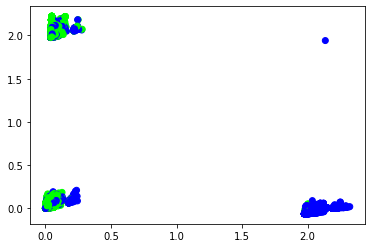

In [148]:
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD #, an alternative to PCA for sparsed matrices

# we use the answers as the color: Green for 'V', Blue for 'N'
answers = ['#00FF00' if example['answer']=='V' else '#0000FF' for example in train_examples]

# We convert our sentences into vectorized representation
joined_sentences = [' '.join(example['keywords']) for example in train_examples]
keywords_list = [example['keywords'] for example in train_examples]
additional_ngrams = [' '.join((tuple_item[0], tuple_item[2], tuple_item[3], tuple_item[1])) for tuple_item in keywords_list]
corpus = [sentence + " " + ngrams for sentence, ngrams in zip(joined_sentences, additional_ngrams)]
vect = CountVectorizer(ngram_range=(1, 4))
sentence_mat = vect.fit_transform(corpus)

# reduce them into 2-D
svd = TruncatedSVD(n_components=2)
svdfit = svd.fit_transform(sentence_mat)

# And plot them
plt.scatter(svdfit[:, 0], svdfit[:, 1], c=answers)

## Machine Learning Experiments

### Simple attempt with Naive Bayes

In [20]:
from sklearn.naive_bayes import MultinomialNB

In [50]:
class NaiveBayesClassifier:
  """
  This naive bayes clasifier is trained using a Multinomial Naive Bayes
  """
  def __init__(self, training_examples: List):

    # convert the data into lists (of sentences / of V/N chars)
    X = [' '.join(example['keywords']) for example in training_examples]
    y = [example['answer'] for example in training_examples]

    # convert the text into numerical values.
    self.vectorizer = CountVectorizer()

    # fit_transforms fits the vectorizer on the test and converts it to vector
    X_transformed = self.vectorizer.fit_transform(X)

    # create a classifier and train it on the data
    self.classifier = MultinomialNB()
    self.classifier.fit(X_transformed, y)

  def classify(self, pp: Tuple):
    # converting the 4-words tuple into a sentnce, separated with spaces: 
    joined_sentence = " ".join(pp)

    # Vectorizing the sentence.
    # The vectorizer accepts a list of sentences, even if we only have one...
    vectorized_sentence = self.vectorizer.transform([joined_sentence])
    
    # classifying the vectorized sentence:
    return self.classifier.predict(vectorized_sentence)

evaluate_classifier(test_examples, NaiveBayesClassifier(train_examples))

0.794431554524362

### Naive bayes with a bigger (brown) corpus

In [51]:
import nltk
from nltk.corpus import brown
nltk.download('brown')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!


True

In [82]:
class NaiveBayesWithBrownTokenizerClassifier:
  """
  This model fits the vectorizer on a bigger corpus (brown).
  The clasifier is trained using a Multinomial Naive Bayes
  """
  def __init__(self, training_examples: List):

    # convert the data into lists (of sentences / of V/N chars)
    X = [' '.join(example['keywords']) for example in training_examples]
    y = [example['answer'] for example in training_examples]

    # convert the text into numerical values. 
    self.vectorizer = CountVectorizer()
    # fit the vectorizer on the brown corpus
    corpus = [" ".join(sent) for sent in brown.sents()]
    self.vectorizer.fit(corpus)
    
    # use the vectorizer to transform the training data into to vector
    X_transformed = self.vectorizer.transform(X)

    # create a classifier and train it on the data
    self.classifier = MultinomialNB()
    self.classifier.fit(X_transformed, y)

  def classify(self, pp: Tuple):
    # converting the 4-words tuple into a sentnce, separated with spaces: 
    joined_sentence = " ".join(pp)
    
    # Vectorizing the sentence.
    # The vectorizer accepts a list of sentences, even if we only have one...
    vectorized_sentence = self.vectorizer.transform([joined_sentence])
    
    # classifying the vectorized sentence:
    return self.classifier.predict(vectorized_sentence)

evaluate_classifier(test_examples, NaiveBayesWithBrownTokenizerClassifier(train_examples))

0.7921113689095127

### Naive Bayes with n-grams

In [40]:
class NaiveBayesNGramClassifier:
  """
  This naive bayes clasifier is trained using a Multinomial Naive Bayes.
  It uses a simple trick of CountVectorizer to create also n-grams of 
  combinations from our 4 words.
  """
  def __init__(self, training_examples: List):

    # convert the data into lists (of sentences / of V/N chars)
    X = [' '.join(example['keywords']) for example in training_examples]
    y = [example['answer'] for example in training_examples]

    # convert the text into numerical values, with ngrams sized 1 to 4:
    self.vectorizer = CountVectorizer(ngram_range=(1, 4))

    # fit_transforms fits the vectorizer on the test and converts it to vector
    X_transformed = self.vectorizer.fit_transform(X)

    # create a classifier and train it on the data
    self.classifier = MultinomialNB()
    self.classifier.fit(X_transformed, y)

  def classify(self, pp: Tuple):
    # converting the 4-words tuple into a sentnce, separated with spaces: 
    joined_sentence = " ".join(pp)

    # Vectorizing the sentence.
    # The vectorizer accepts a list of sentences, even if we only have one...
    vectorized_sentence = self.vectorizer.transform([joined_sentence])
    
    # classifying the vectorized sentence:
    return self.classifier.predict(vectorized_sentence)

evaluate_classifier(test_examples, NaiveBayesNGramClassifier(train_examples))

0.8193348801237432

### Naive Bayes with full n-grams (also v-p & v-p-n2)

In [44]:
class NaiveBayesFullNGramClassifier:
  """
  This naive bayes clasifier is trained using a Multinomial Naive Bayes.
  It uses a simple trick of CountVectorizer to create also n-grams of 
  combinations from our 4 words.

  In addition, we ensure that all the tuples are there.
  """
  def __init__(self, training_examples: List):

    # convert the data into lists (of ngram sentences / of V/N chars)
    keywords_list = [example['keywords'] for example in train_examples]
    X = self.generate_ngram_sentences(keywords_list)
    y = [example['answer'] for example in training_examples]

    # convert the text into numerical values, with ngrams sized 1 to 4:
    self.vectorizer = CountVectorizer(ngram_range=(1, 4))

    # fit_transforms fits the vectorizer on the test and converts it to vector
    X_transformed = self.vectorizer.fit_transform(X)

    # create a classifier and train it on the data
    self.classifier = MultinomialNB()
    self.classifier.fit(X_transformed, y)

  def generate_ngram_sentences(self, tuple_list: List):
    joined_sentences = [" ".join(keywords) for keywords in tuple_list]
    additional_ngrams = [' '.join((tuple_item[0], tuple_item[2], tuple_item[3])) for tuple_item in tuple_list]
    final_sentences = [sentence + " " + ngrams for sentence, ngrams in zip(joined_sentences, additional_ngrams)]
    return final_sentences

  def classify(self, pp: Tuple):
    # converting the 4-words tuple into a sentence with the additional words
    # for better n-grams.
    # Pay attention that `generate_ngram_sentences` expects a list of tuples,
    # so we must convert it into a list:
    joined_sentence = self.generate_ngram_sentences([pp])

    # Vectorizing the sentence.
    # The vectorizer accepts a list of sentences, and our method
    # `generate_ngram_sentences` already returns one - so no [] around it:
    vectorized_sentence = self.vectorizer.transform(joined_sentence)
    
    # classifying the vectorized sentence:
    return self.classifier.predict(vectorized_sentence)

evaluate_classifier(test_examples, NaiveBayesFullNGramClassifier(train_examples))

0.8232018561484918

### Naive bayes  with additional lemmatized features

In [49]:
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [77]:
class NaiveBayesWithLemmaFeaturesClassifier:
  """
  This model adds additional features by lemmatizing nouns and verbs.
  The clasifier is trained using a Multinomial Naive Bayes
  """
  def __init__(self, training_examples: List):
    self.lemmatizer = WordNetLemmatizer()
    
    # convert the data into lists (of sentences / of V/N chars)
    X = [' '.join(example['keywords']) for example in training_examples]
    y = [example['answer'] for example in training_examples]

    # convert the text into numerical values. 
    self.vectorizer = CountVectorizer(ngram_range=(1, 4))
    X_transformed = self.vectorizer.fit_transform(X)
    
    # create a classifier and train it on the data
    self.classifier = MultinomialNB()
    self.classifier.fit(X_transformed, y)

  def transform_example(self, example: Tuple) -> List:
    # we lemmatize the verb:
    lemmatized_v = self.lemmatizer.lemmatize(example[0], 'v')

    # and the 2 nouns:
    lemmatized_n1 = self.lemmatizer.lemmatize(example[1], 'n')
    lemmatized_n2 = self.lemmatizer.lemmatize(example[3], 'n')

    # then we combine them all together into one single list, including the
    # preposition (which we didn't touch)
    features = [lemmatized_v, lemmatized_n1, example[2], lemmatized_n2]
    return " ".join(features)
    
  def classify(self, pp: Tuple):
    # converting the 4-words tuple into a sentnce, together with the lemmas: 
    joined_sentence = self.transform_example(pp)

    # Vectorizing the sentence.
    # The vectorizer accepts a list of sentences, even if we only have one...
    vectorized_sentence = self.vectorizer.transform([joined_sentence])

    # classifying the vectorized sentence:
    return self.classifier.predict(vectorized_sentence)

evaluate_classifier(test_examples, NaiveBayesWithLemmaFeaturesClassifier(train_examples))

0.8009280742459397

### Support Vector Machine

In [51]:
from sklearn.svm import SVC


In [57]:
class SupportVectorClassifier:
  """
  This naive bayes clasifier is trained using a Support Vector Machine
  """
  def __init__(self, training_examples: List):

    # convert the data into lists (of sentences / of V/N chars)
    X = [' '.join(example['keywords']) for example in training_examples]
    y = [example['answer'] for example in training_examples]

    # convert the text into numerical values. 
    self.vectorizer = CountVectorizer()

    # fit_transforms fits the vectorizer on the test and converts it to vector
    X_transformed = self.vectorizer.fit_transform(X)

    # create a classifier and train it on the data
    self.classifier = SVC()
    self.classifier.fit(X_transformed, y)

  def classify(self, pp: Tuple):
    # converting the 4-words tuple into a sentnce, separated with spaces: 
    joined_sentence = " ".join(pp)

    # Vectorizing the sentence.
    # The vectorizer accepts a list of sentences, even if we only have one...
    vectorized_sentence = self.vectorizer.transform([joined_sentence])

    # classifying the vectorized sentence:
    return self.classifier.predict(vectorized_sentence)

evaluate_classifier(test_examples, SupportVectorClassifier(train_examples))

0.8218097447795824

### Support Vector Machine with Brown Corpus

In [84]:

class SVCWithBrownTokenizerClassifier:
  """
  This model fits the vectorizer on a bigger corpus (brown).
  The clasifier is trained using a Support Vector Machine
  """
  def __init__(self, training_examples: List):

    # convert the data into lists (of sentences / of V/N chars)
    X = [' '.join(example['keywords']) for example in training_examples]
    y = [example['answer'] for example in training_examples]

    # convert the text into numerical values, including n-grams of up to 5
    # words
    self.vectorizer = CountVectorizer(ngram_range=(1, 5))

    # fit the vectorizer on the brown corpus
    corpus = [" ".join(sent) for sent in brown.sents()]
    self.vectorizer.fit(corpus)
    
    # use the vectorizer to transform the training data into to vector
    X_transformed = self.vectorizer.transform(X)

    # create a classifier and train it on the data
    self.classifier = SVC()
    self.classifier.fit(X_transformed, y)

  def classify(self, pp: Tuple):
    # converting the 4-words tuple into a sentnce, separated with spaces: 
    joined_sentence = " ".join(pp)

    # Vectorizing the sentence.
    # The vectorizer accepts a list of sentences, even if we only have one...
    
    vectorized_sentence = self.vectorizer.transform([joined_sentence])
    # classifying the vectorized sentence:
    return self.classifier.predict(vectorized_sentence)

evaluate_classifier(test_examples, SVCWithBrownTokenizerClassifier(train_examples))


0.8292343387470997

### Support Vector Machine with Lemmatized Features

In [59]:
class SVCWithLemmaFeaturesClassifier:
  """
  This model adds additional features as lemmatized nouns and verbs.
  The clasifier is trained using a Support Vector Machine
  """
  def __init__(self, training_examples: List):
    self.lemmatizer = WordNetLemmatizer()
    
    # convert the data into lists (of sentences / of V/N chars)
    X = [self.transform_example(example['keywords']) for example in training_examples]
    y = [example['answer'] for example in training_examples]

    # convert the text into numerical values. 
    self.vectorizer = CountVectorizer()
    X_transformed = self.vectorizer.fit_transform(X)
    
    # create a classifier and train it on the data
    self.classifier = SVC()
    self.classifier.fit(X_transformed, y)

  def transform_example(self, example: Tuple) -> List:
    lemmatized_v = self.lemmatizer.lemmatize(example[0], 'v')
    lemmatized_n1 = self.lemmatizer.lemmatize(example[1], 'n')
    lemmatized_n2 = self.lemmatizer.lemmatize(example[3], 'n')

    features = set([lemmatized_v, lemmatized_n1, lemmatized_n2] + list(example))
    return " ".join(features)
    
  def classify(self, pp: Tuple):
    # converting the 4-words tuple into a sentnce, together with the lemmas: 
    joined_sentence = self.transform_example(pp)

    # Vectorizing the sentence.
    # The vectorizer accepts a list of sentences, even if we only have one...
    vectorized_sentence = self.vectorizer.transform([joined_sentence])
     
    # classifying the vectorized sentence:
    return self.classifier.predict(vectorized_sentence)

evaluate_classifier(test_examples, SVCWithLemmaFeaturesClassifier(train_examples))

0.8278422273781902

### Support Vector Machine with both Lemmaized version and n-grams

In [70]:
class SVCWithNGramAndLemmasClassifier:
  """
  This model uses n-grams when fitting the vectorizer and uses lemmatized nouns 
  and verbs. There are many possible combinations of the n-grams and the
  feature-vector. The best we found for this data was n-grams of 1-2 words, 
  run simply on lemmatized version of the noun and verbs.
  
  The clasifier is trained using a Support Vector Machine
  """
  def __init__(self, training_examples: List):
    self.lemmatizer = WordNetLemmatizer()

    # convert the data into lists (of sentences / of V/N chars)
    X = [self.transform_example(example['keywords']) for example in training_examples]
    y = [example['answer'] for example in training_examples]

    # convert the text into numerical values. 
    self.vectorizer = CountVectorizer(ngram_range=(1, 2))
    X_transformed = self.vectorizer.fit_transform(X)
    
    # create a classifier and train it on the data
    self.classifier = SVC()
    self.classifier.fit(X_transformed, y)

  def transform_example(self, example: Tuple) -> List:
    lemmatized_v = self.lemmatizer.lemmatize(example[0], 'v')
    lemmatized_n1 = self.lemmatizer.lemmatize(example[1], 'n')
    lemmatized_n2 = self.lemmatizer.lemmatize(example[3], 'n')

    # here we just use the lemmatized words (and the preposition)
    features = [lemmatized_v, lemmatized_n1, example[2], lemmatized_n2]
    return " ".join(features)

  def classify(self, pp: Tuple):
    # converting the 4-words tuple into a sentnce, with lemma features: 
    joined_sentence = self.transform_example(pp)

    # Vectorizing the sentence.
    # The vectorizer accepts a list of sentences, even if we only have one...
    vectorized_sentence = self.vectorizer.transform([joined_sentence])

    # classifying the vectorized sentence:
    return self.classifier.predict(vectorized_sentence)

evaluate_classifier(test_examples, SVCWithNGramAndLemmasClassifier(train_examples))

0.8293890177880897

### Support Vector Machine with more lemmatized n-grams (v, p, n2...)

In [52]:
class SVCWithNFullGramAndLemmasClassifier:
  """
  This SVM's features are concatenated with lemmatized words, so that the
  n-gram generator will create all possible combinations:
  v, n1, p, n2, v-n1, n1-p, p-n2, v-n1-p, n1-p-n2, v-n1-p-n2, and even
  v-p-n2 (without n1) + all of which using a lemmatized version.
  """
  def __init__(self, training_examples: List):
    self.lemmatizer = WordNetLemmatizer()

    # convert the data into lists (of ngram sentences / of V/N chars)
    keywords_list = [example['keywords'] for example in train_examples]
    X = self.generate_ngram_sentences(keywords_list)
    y = [example['answer'] for example in training_examples]

    # convert the text into numerical values, with ngrams sized 1 to 4:
    self.vectorizer = CountVectorizer(ngram_range=(1, 4))

    # fit_transforms fits the vectorizer on the test and converts it to vector
    X_transformed = self.vectorizer.fit_transform(X)

    # create a classifier and train it on the data
    self.classifier = SVC()
    self.classifier.fit(X_transformed, y)

  def generate_ngram_sentences(self, tuple_list: List):
    joined_sentences = [" ".join(keywords) for keywords in tuple_list]
    additional_ngrams = [' '.join(self.lemmatize_example(tuple_item)) for tuple_item in tuple_list]
    final_sentences = [sentence + " " + lemmatized_ngrams for sentence, lemmatized_ngrams in zip(joined_sentences, additional_ngrams)]
    return final_sentences

  def lemmatize_example(self, word_tuple):
    # Given a word-tuple, returns a lemmatized version of the words 
    # in different order for the n-grams
    lemmatized_v = self.lemmatizer.lemmatize(word_tuple[0], 'v')
    lemmatized_n1 = self.lemmatizer.lemmatize(word_tuple[1], 'n')
    lemmatized_n2 = self.lemmatizer.lemmatize(word_tuple[3], 'n')

    return (lemmatized_v, lemmatized_n1, word_tuple[2], lemmatized_n2, lemmatized_v, word_tuple[2], lemmatized_n2)

  def classify(self, pp: Tuple):
    # converting the 4-words tuple into a sentence with the additional words
    # for better n-grams.
    # Pay attention that `generate_ngram_sentences` expects a list of tuples,
    # so we must convert it into a list:
    joined_sentence = self.generate_ngram_sentences([pp])

    # Vectorizing the sentence.
    # The vectorizer accepts a list of sentences, and our method
    # `generate_ngram_sentences` already returns one - so no [] around it:
    vectorized_sentence = self.vectorizer.transform(joined_sentence)
    
    # classifying the vectorized sentence:
    return self.classifier.predict(vectorized_sentence)

evaluate_classifier(test_examples, SVCWithNFullGramAndLemmasClassifier(train_examples))

0.8188708430007734

### Ensemble classifiers

In [90]:
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

In [87]:

class MultipleVotingClassifier:
  """
  This model fits the vectorizer on a bigger corpus (brown).
  The clasifier is trained using a Support Vector Machine
  """
  def __init__(self, training_examples: List):  

    # convert the data into lists (of sentences / of V/N chars)
    X = [' '.join(example['keywords']) for example in training_examples]
    y = [example['answer'] for example in training_examples]

    # convert the text into numerical values. 
    self.vectorizer = CountVectorizer(ngram_range=(1,4))
    
    # use the vectorizer to transform the training data into to vector
    X_transformed = self.vectorizer.fit_transform(X)

    # create the classifiers and train them on the data through voting
    clf1 = SVC()
    clf2 = MultinomialNB()
    clf3 = RandomForestClassifier(n_estimators=50, random_state=1234)

    self.classifier = VotingClassifier(estimators=[
        ('svc', clf1), ('mnb', clf2), ('rfc', clf3)], voting='hard')

    self.classifier.fit(X_transformed, y)

  def classify(self, pp: Tuple):
    # converting the 4-words tuple into a sentnce, separated with spaces: 
    joined_sentence = " ".join(pp)

    # Vectorizing the sentence.
    # The vectorizer accepts a list of sentences, even if we only have one...    
    vectorized_sentence = self.vectorizer.transform([joined_sentence])

    # classifying the vectorized sentence:
    return self.classifier.predict(vectorized_sentence)

evaluate_classifier(test_examples, MultipleVotingClassifier(train_examples))

0.8204176334106729

In [93]:
class AdaBstClassifier:
  """
  """
  def __init__(self, training_examples: List):
    self.lemmatizer = WordNetLemmatizer()

    # convert the data into lists (of sentences / of V/N chars)
    X = [self.transform_example(example['keywords']) for example in training_examples]
    y = [example['answer'] for example in training_examples]

    # convert the text into numerical values. 
    self.vectorizer = CountVectorizer(ngram_range=(1, 4))
    X_transformed = self.vectorizer.fit_transform(X)
    
    # create a classifier and train it on the data
    self.classifier = AdaBoostClassifier(n_estimators=100, random_state=1234)
    self.classifier.fit(X_transformed, y)

  def transform_example(self, example: Tuple) -> List:
    lemmatized_v = self.lemmatizer.lemmatize(example[0], 'v')
    lemmatized_n1 = self.lemmatizer.lemmatize(example[1], 'n')
    lemmatized_n2 = self.lemmatizer.lemmatize(example[3], 'n')

    # here we just use the lemmatized words (and the preposition)
    features = [lemmatized_v, lemmatized_n1, example[2], lemmatized_n2]
    return " ".join(features)

  def classify(self, pp: Tuple):
    # converting the 4-words tuple into a sentnce, with lemma features: 
    joined_sentence = self.transform_example(pp)

    # Vectorizing the sentence.
    # The vectorizer accepts a list of sentences, even if we only have one...
    vectorized_sentence = self.vectorizer.transform([joined_sentence])

    # classifying the vectorized sentence:
    return self.classifier.predict(vectorized_sentence)

evaluate_classifier(test_examples, AdaBstClassifier(train_examples))

0.7832946635730859

## Using BytePairEmbedding

In [61]:
!pip install bpemb --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 21.2 MB/s eta 0:00:00


In [ ]:
import numpy as np

from bpemb import BPEmb

In [65]:
class SVCWithBpEmbClassifier:
  """
  """
  def __init__(self, training_examples: List):
    self.vectorizer = BPEmb(lang="en").embed

    # convert the data into lists (of sentences / of V/N chars)
    X = np.array([np.hstack([self.vectorizer(word).mean(axis=0) for word in example['keywords']]) for example in training_examples])
    y = [example['answer'] for example in training_examples]

    # create a classifier and train it on the data
    self.classifier = SVC()
    self.classifier.fit(X, y)

  def classify(self, pp: Tuple):
    # Vectorizing the tuple.
    vectorized_sentence = np.hstack([self.vectorizer(word).mean(axis=0) for word in pp]).reshape(1, -1)

    # classifying the vectorized sentence:
    return self.classifier.predict(vectorized_sentence)

evaluate_classifier(test_examples, SVCWithBpEmbClassifier(train_examples))


0.8402165506573859

Let's try KNN on the BPEmbedding because why not...

In [63]:
class KNNWithBpEmbClassifier:
  """
  We try the KNN on the bytepair embedding, since it could be that similar 
  vectors would be groupped together in the embedding space.
  """
  def __init__(self, training_examples: List):
    self.vectorizer = BPEmb(lang="en").embed

    # convert the data into lists (of sentences / of V/N chars)
    X = np.array([np.hstack([self.vectorizer(word).mean(axis=0) for word in example['keywords']]) for example in training_examples])
    y = [example['answer'] for example in training_examples]

    # create a classifier and train it on the data
    self.classifier = KNeighborsClassifier()
    self.classifier.fit(X, y)

  def classify(self, pp: Tuple):
    # Vectorizing the tuple.
    vectorized_sentence = np.hstack([self.vectorizer(word).mean(axis=0) for word in pp]).reshape(1, -1)

    # classifying the vectorized sentence:
    return self.classifier.predict(vectorized_sentence)

evaluate_classifier(test_examples, KNNWithBpEmbClassifier(train_examples))


0.7931941221964424

## Summary
The PP attachment problem is a real-world problm, and not yet entirely solved.

[Many different researchers](https://www.dline.info/jcl/fulltext/v9n2/jclv9n2_2.pdf) are trying to tackle this issue: Some using [verbnet semantic features](https://aclanthology.org/W15-0102.pdf); [some with TreeNet](https://aclanthology.org/H05-1035.pdf); Others with [semantic trees](https://www.researchgate.net/publication/228946783_Prepositional_phrase_attachment_ambiguity_resolution_using_semantic_hierarchies). 

Modern methods include using distributed representation (word2vec and friends) and the contextualized representation (which requires the whole sentence), such as ELMo, BERT, RoBERTa, etc, demonstrate already a higher level of accuracy when it comes to this task.